# ML Image Segmentation

**Author:** Dmitry Chezganov (GitHub: [DexterChe](https://github.com/DexterChe))  
**Created on:** 21/10/2024   

## Description

This script processes SEM images in a folder, performing segmentation, feature size measurement, and plotting distributions. The original images used as examples in this code are represented by SEM images of ferroelectric domains created by defocused electron beam (e-beam) irradiation or e-beam low-dose scanning of the surface of lithium niobate single crystals coated with a photoresist layer. The domain structures are revealed at the surface through selective etching with HF acid and are represented by hills that do not overlap and rarely touch each other. In principle, the image analysis procedure can be applied to any kind of particle, even overlapping ones, with the proper choice of NN model and parameter adjustment.

### Example of the image
![Example image](https://raw.githubusercontent.com/DexterChe/ML_img_segm_and_analysis/main/image_example/D50_10kV_1_row_005.tif)


## Main Steps:

1. Import necessary libraries.
2. Define functions for creating folders, labeling images, and calculating the minimum Feret diameter.
3. Set paths to images and models.
4. Create folders to save results.
5. Process images using the FastSAM model.
6. Save results and plot distributions.

## Libraries Used:

- `ultralytics`
- `cv2`
- `matplotlib`
- `time`
- `os`
- `glob`
- `hyperspy`
- `pandas`
- `random`
- `numpy`
- `skimage`
- `torch`
- `tqdm`
- `gc`

## Note

This script requires pre-trained models for image segmentation, such as SAM, MobileSAM, YOLO, and FastSAM. Ensure that the paths to the models are correctly specified or they will be downloaded automatically

## Installation
For the datails of installation procedure for ultralytics python package please navigate to [Ultralitics](https://docs.ultralytics.com/quickstart/#install-ultralytics).
It is recommended, but not required, that your Windows system has an NVIDIA GPU in order to harness the full power of PyTorch’s CUDA support.
For this you need to unstll cuda first. For the instruction please navigate to [pythorch.org](https://pytorch.org/get-started/locally/).

In [ ]:
%pip install ultralytics tqdm hyperspy

## Import libraries

In [1]:
from ultralytics import SAM
from ultralytics import YOLO
from ultralytics import FastSAM
from ultralytics.models.fastsam import FastSAMPrompt
import cv2
import matplotlib.pyplot as plt
import os
import glob
import hyperspy.api as hs
import pandas as pd
import random
import numpy as np
from skimage.measure import label, regionprops
from skimage.color import label2rgb
from skimage import filters
import pandas as pd
import time
import torch
# progress bar
from tqdm.notebook import tqdm
import gc
import platform

## Check if Cuda is available

In [2]:
import torch
print('Cuda is available',torch.cuda.is_available())
print('Number of GPU available', torch.cuda.device_count())
if torch.cuda.is_available():
    print('Current GPU device #:', torch.cuda.current_device())
    print('GPU Name:', torch.cuda.get_device_name(torch.cuda.current_device()))

Cuda is available True
Number of GPU available 1
Current GPU device #: 0
GPU Name: NVIDIA GeForce RTX 2060


## Check for the current platform in use

In [3]:
# Get the current platform
current_platform = platform.system()
print('Current platform:', current_platform)

Current platform: Windows


## Some usefull functions to use further in the code

This code snippet defines three functions used in the image segmentation and analysis process:

1. **`make_folder`**:
   - This function creates a folder to save the output of the experiment.
   - It takes two arguments: the path to the folder where the output should be saved (`save_path`), and the name of the folder (`folder_name`).
   - If the folder already exists, it will not be overwritten, and a message will be printed.
   - If the folder does not exist, it will be created.
   - The function returns the path to the output folder.

2. **`image_labeling`**:
   - This function labels the regions in a given image using Otsu's thresholding method.
   - It takes one argument: the input image (`image`), which can be a grayscale or color image.
   - If the image has more than 2 dimensions, it will be converted to grayscale.
   - The function applies Otsu's thresholding to create a binary image and then labels the regions in the binary image.
   - The function returns the labeled image, where each region is assigned a unique integer label.

3. **`minimal_feret_diameter`**:
   - This function calculates the minimal Feret diameter of the objects in a binary image.
   - The minimal Feret diameter is defined as the smallest distance between two parallel tangents to the contour of an object in the image.
   - It takes one argument: a binary image (`binary_image`), where objects are represented by white pixels (255) and the background is represented by black pixels (0).
   - The function finds the contours of the objects in the binary image and computes the minimal Feret diameter for each object.
   - The function returns the minimal Feret diameter of the objects in the binary image.

These functions are essential for creating output directories, labeling image regions, and calculating specific measurements of the segmented objects.

In [4]:
def make_folder(save_path, folder_name):
    """
    Create a folder to save the output
    This function creates a folder for the output of the experiment.
    It takes two arguments: the path to the folder where the output should be saved, and the name of the folder.
    If the folder already exists, it will not be overwritten, but a message will be printed.
    The function returns the path to the output folder.

    Args:
        save_path (str): folder where to create the folder to save results
        folder_name (str): folder to save results

    Returns:
        str: path to folder to save results
    """
    # Check if the folder already exists
    if not os.path.exists(os.path.join((save_path + folder_name))):
        try:
            # If it doesn't exist, create the folder
            os.makedirs(os.path.join(save_path + folder_name))
        except OSError: 
            # If the creation of the folder failed, print a message
            print(f'Creation of the directory {os.path.join(save_path + folder_name)} failed. Probably already present.')
    else:
        # If the folder already exists, print a message
        print(f'Directory {os.path.join(save_path + folder_name)} already exists.')
    # Return the path to the folder
    if current_platform == 'Windows':
        path_to_save = save_path +folder_name+'\\'
    else:
        path_to_save = save_path +folder_name+'/'
    print(f'The folder {path_to_save} has been created.')
    return path_to_save

# labeling images
def image_labeling(image):
    """
    Labels the regions in a given image using Otsu's thresholding method.
    Parameters:
    image (numpy.ndarray): Input image. If the image has more than 2 dimensions, 
    it will be converted to grayscale.
    
    Returns:
    numpy.ndarray: Labeled image where each region is assigned a unique integer label.
    """
    if image.ndim > 2:
        # convert to grayscale
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
    else:
        image = image
    # Define a threshold by Otsu method
    threshold = filters.threshold_otsu(image)
    # Application of thresholding to an image to get binary image 
    binary_image = image > threshold
    im_b = binary_image

    label_image = label(im_b)  # normalize to the range 0.0 - 1.0

    return label_image

# minimal Feret diameter
def minimal_feret_diameter(binary_image):
    """
    Calculate the minimal Feret diameter of the objects in a binary image.
    The minimal Feret diameter is defined as the smallest distance between two parallel tangents 
    to the contour of an object in the image. This function finds the contours of the objects in 
    the binary image and computes the minimal Feret diameter for each object.
    Parameters:
    binary_image (numpy.ndarray): A binary image where the objects are represented by white pixels (255) 
    and the background is represented by black pixels (0).

    Returns:
    float: The minimal Feret diameter of the objects in the binary image.
    """
    # Find contours in the binary image
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    min_feret_diameter = float('inf')  # Start with an infinitely large value
    
    for contour in contours:
        # Calculate the rotating bounding box
        rect = cv2.minAreaRect(contour)
        (x, y), (width, height), angle = rect
        
        # The minimal Feret diameter is the smallest side of the rectangle
        min_feret_diameter = min(min_feret_diameter, min(width, height))
    
    return min_feret_diameter

def to_raw_string(path):
    """
    Converts a given file path to a raw string format by replacing backslashes with double backslashes.

    Args:
    path (str): The file path to be converted.

    Returns:
    str: The converted raw string file path.
    """
    return path.replace("\'", "\\\\")

## Define paths to the folder with images and models
Paths to models are optional since it loads automatically (internet access required)

In [ ]:
#* path to a folder with images
path_to_folder = r"\images\\"


# Define the path depending on the platform
if current_platform == 'Windows':
    path_to_folder = to_raw_string(path_to_folder)
elif current_platform == 'Darwin':  # macOS
    path_to_folder = path_to_folder
else:
    raise NotImplementedError(f"Platform {current_platform} is not supported")

print(path_to_folder)

#* path to models
# There are 4 types of models available (and there are some models for each type):
# 1. path to SAM models
# https://docs.ultralytics.com/models/sam/
path_to_model_SAM_l = '/Models/sam_l.pt'
path_to_model_SAM_b = '/Models/sam_b.pt'

#2. path to MobileSAM models
# https://docs.ultralytics.com/ru/models/mobile-sam/
path_to_model_MobileSAM = '/Models/mobile_sam.pt'

# 3. path to YOLO models
# https://docs.ultralytics.com/ru/tasks/segment/
path_to_model_YOLOv8n = '/Models/yolov8n-seg.pt'
path_to_model_YOLOv8m = '/Models/yolov8m-seg.pt'
path_to_model_YOLOv8s = '/Models/yolov8s-seg.pt'
path_to_model_YOLOv8x = '/Models/yolov8x-seg.pt'

# 4. path to FastSAM models
# https://docs.ultralytics.com/models/fast-sam/
path_to_model_FastSAM_x = '/Models/FastSAM-x.pt'
path_to_model_FastSAM_s = '/Models/FastSAM-s.pt'

## Define paths to save results 

In [ ]:
#* path to save the results
# today's date
today = time.strftime("%Y-%m-%d")
#!common path to save
path_to_save = make_folder(path_to_folder, today+'_Segmentation_results_test_'+current_platform)

#* create all folders and set up paths
# images with red masks to see if there are overlay (shown by darker red)
path_to_save_images_red = make_folder(path_to_save, 'images_red')
# more images with masks and annotations + conf index in ann
path_to_save_ann = make_folder(path_to_save, 'images_ann')
# distributions of areas per image
path_to_save_hists = make_folder(path_to_save, 'images_hist')
# areas
path_to_save_areas = make_folder(path_to_save, 'images_areas')
# images with particle numbers
path_to_save_numbers = make_folder(path_to_save, 'images_ann_numbers')
# folders with images of individual particles
path_to_save_particles = make_folder(path_to_save, 'images_particles')


## Make list of files in the folder as well as define a file name

This code snippet is responsible for gathering and sorting the list of image files to be processed. The main steps are as follows:

1. **Gathering Files**:
   - Use the `glob` module to find all `.tif` files in the specified folder (`path_to_folder`).
   - Store the list of file paths in the variable `list_of_files`.

2. **Sorting Files**:
   - Sort the list of file paths to ensure they are processed in a consistent order.

3. **Counting Files**:
   - Calculate the total number of files found and store it in the variable `N`.
   - Print the number of files to the console.

4. **Extracting File Names**:
   - Extract the base name (file name without the path) of the first file in the list and store it in the variable `file_name`.
   - Create a list of base names for all files in `list_of_files` and store it in the variable `file_names`.

This code prepares the list of image files for subsequent processing steps by ensuring they are sorted and their names are easily accessible.

In [9]:
list_of_files = glob.glob(path_to_folder + '/*.tif')
#sort
list_of_files.sort()
N = len(list_of_files)
print(f'Number of files in the folder: {N}')

#file name
file_name = os.path.basename(list_of_files[0])
file_names = [os.path.basename(file) for file in list_of_files]

Number of files in the folder: 12


## Read pixel size

In [10]:
s = hs.load(list_of_files[0])
px_size = s.axes_manager[0].scale*10**9

## Main part for image segmentation

This code performs image segmentation on a batch of SEM images using the FastSAM model. The main steps are as follows:

1. **Initialization**:
   - Set the model name and batch size.
   - Create a folder to save the results of the prompt process.
   - Initialize a DataFrame to store the number of particles detected in each file.

2. **Processing Loop**:
   - Loop over the list of image files in batches.
   - For each batch:
     - Load the FastSAM model.
     - Perform segmentation on the batch of images.
     - Initialize a `FastSAMPrompt` object with the segmentation results.
     - Generate and plot annotations for the segmented images.
     - Save the annotated images.

3. **Saving Results**:
   - For each image in the batch:
     - Extract the path and name of the original file.
     - Create a folder to save cropped images.
     - Save images with red annotations.
     - Load the original image and create copies for further processing.
     - Initialize a DataFrame to store measurement results.
     - Plot masks and boxes on the images and save the results.
     - Crop the images based on the bounding boxes and save the cropped images.
     - Label the cropped images and compute region properties.
     - Save the measurement results to the DataFrame.
     - Plot and save distributions of particle properties.

4. **Memory Management**:
   - Clear the memory and GPU cache after processing each batch.

5. **Final Steps**:
   - Save the number of particles detected in each file to a CSV file.
   - Print the total processing time.

This code ensures that the SEM images are processed efficiently in batches, and the results are saved for further analysis.

In [ ]:
model_name4 = 'FastSAM_s'
# count time
start = time.time()
print(f'Processing started...\n')
#* path to save the results from prompt_process.plot
path_to_save_promt = make_folder(path_to_save, 'promt_process/')

#! Decrease the batch size if the model does not fit into the memory
batch_size = 12  # New batch size
print(f'New batch size: {batch_size}\n')

# DataFrame to save number of particles
number_of_particles_DF = pd.DataFrame(columns=['File', 'Number_of_particles'])

# check for device
device = 'cuda' if torch.cuda.is_available() else 'cpu'


# loop over the files
for i in range(0, len(list_of_files), batch_size):
    print(f'Processing files from {i}/{N} to {i+batch_size}/{N}\n')
    batch_files = list_of_files[i:i+batch_size]
    
        # * Create a FastSAM model
    model = FastSAM()  # or FastSAM-x.pt
    # # model = FastSAM(path_to_model_FastSAM_x)  # or FastSAM-x.pt
    # everything_results = model(
    #     batch_files,
    #     device=device, 
    #     retina_masks=True, 
    #     imgsz=(768, 1024),
    #     conf=0.25, 
    #     iou=0.3,
    #     max_det=700
    # )
    try:
        print(f'Processing files: {batch_files}\n')
        everything_results = model(batch_files, device=device, retina_masks=True, imgsz=(768, 1024), conf=0.25, iou=0.3, max_det=700)
        # Proceed with further processing only if everything_results is successful
        prompt_process = FastSAMPrompt(batch_files, everything_results, device=device)

        # Everything prompt
        ann = prompt_process.everything_prompt()
        prompt_process.plot(
                        annotations=ann, 
                        output=path_to_save_promt,
                        bbox=None,
                        points=None,
                        point_label=None,
                        mask_random_color=True,
                        better_quality=True,
                        retina=True,
                        with_contours=False
                                        )
        # Continue processing
    except OSError as e:
        print(f"Error processing {batch_files}: {e}")
    except NameError as e:
        print(f"Skipping file due to undefined variable: {e}")
    except Exception as e:
        print(f"Unexpected error processing {batch_files}: {e}")


    #* save areas of the masks to files
    for j, file in tqdm(enumerate(everything_results)):

        # extaract path to the original file
        path_to_file = file.path
        # name of the file
        file_name = os.path.basename(path_to_file).split('.')[0]
        # create folder to save crops 
        path_to_save_crops = make_folder(path_to_save_particles, file_name)

        # save images with red annotations
        file.plot(show=False, 
                    labels=False, 
                    boxes=False, 
                    masks=True,
                    save=True,
                    filename=path_to_save_images_red+f'{file_name}_{model_name4}'+'.jpg')
        # * save images with annotations with conf values
        # file.save(filename=path_to_save_ann+f'{file_name}_{model_name4}'+'.png')

        # load original image
        image = cv2.imread(path_to_file)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # make a copy of image to apply boxes
        image_with_boxes = image.copy()
        # # DataFrame to save the results of measurements
        results_DF = pd.DataFrame(columns=['Area_px', 'Major_axis_length_px', 'Minor_axis_length_px', 'Equivalent_diameter_px', 'Max_Feret_diameter_px', 'Min_Feret_diameter_px', 'Area_nm', 'Major_axis_length_nm', 'Minor_axis_length_nm', 'Equivalent_diameter_nm', 'Max_Feret_diameter_nm', 'Min_Feret_diameter_nm'])

        # plot the masks and boxes on the images with numbers of detected partcile
        fig, ax = plt.subplots(dpi=300)
        ax.imshow(image)
        for k in range(len(file.masks)):
            # extract the mask and box for the particle 
            mask = file.masks[k]
            box = file.boxes[k]
            # aasign a random color to the mask and box contour
            color = (random.random(), random.random(), random.random())  # random color

            #* crop the image by boxes +/- 10 px
            # extract coordinates of the box
            # x1, y1, x2, y2 = map(int, box.xyxy.numpy().flatten()) #! for MAC
            # x1, y1, x2, y2 = map(int, box.xyxy.cpu().numpy().flatten()) #! for Windows
            # Check current platform
            current_platform = platform.system()

            # Depending on the platform, extract the coordinates of the box
            if current_platform == 'Darwin':  # macOS
                x1, y1, x2, y2 = map(int, box.xyxy.numpy().flatten())
            elif current_platform == 'Windows':  # Windows
                x1, y1, x2, y2 = map(int, box.xyxy.cpu().numpy().flatten())
            else:
                raise NotImplementedError(f"Platform {current_platform} is not supported")
            # increase the crop area by 10 pixels in all directions
            x1_l = max(0, x1 - 10)
            y1_l = max(0, y1 - 10)
            x2_l = min(image_with_boxes.shape[1], x2 + 10)
            y2_l = min(image_with_boxes.shape[0], y2 + 10)
            # make a tuple of the color for RGB channels
            color_tuple =tuple([int(255 * c) for c in color])

            # make a copy of image to apply masks
            image_with_masks = image.copy()
            # create an empty image for the mask
            mask_image = np.zeros_like(image_with_masks)
            # get coordinates of the mask countour
            countour = np.array(mask.xy[0]).reshape((-1, 1, 2)).astype(np.int32)
            # fill the the area inside the mask with the color
            cv2.fillPoly(mask_image, [countour], color=color_tuple)
            # add the mask to the image
            # image_with_masks = cv2.add(mask, mask_image)
            # add the mask to the image
            image_with_masks = cv2.addWeighted(image_with_masks, 0.5, mask_image, 0.5, 0)
            # assign values to the upper and lower boundaries of the contour
            image_with_boxes[y1, x1:x2-1] = color_tuple
            image_with_boxes[y2-1, x1:x2-1] = color_tuple

            # aasign a random color to the mask and box contour
            image_with_boxes[y1:y2-1, x1] = color_tuple
            image_with_boxes[y1:y2-1, x2-1] = color_tuple

            #crop the image
            crop = image_with_boxes[y1_l:y2_l, x1_l:x2_l]
            crop_original = image[y1_l:y2_l, x1_l:x2_l]
            crop_mask = image_with_masks[y1_l:y2_l, x1_l:x2_l]
            # make array with 0s of crop_maks size
            mask_array = np.zeros_like(image_with_masks)
            # fill the the area inside the mask with the color
            cv2.fillPoly(mask_array, [countour], color=(255, 255, 255))
            # crop mask array
            crop_mask_array = mask_array[y1_l:y2_l, x1_l:x2_l]

            # im_crop_mask = crop_mask.copy()
            # labeling the image #! check the mask for labeling
            label_image = image_labeling(crop_mask_array)
            # compute region properties
            props = regionprops(label_image)
            area_px = props[0].area # area of the particle
            area_nm = area_px * px_size**2 # area in nm^2
            major_axis_length_px = props[0].major_axis_length # major axis length
            major_axis_length_nm = major_axis_length_px * px_size # major axis length in nm
            minor_axis_length_px = props[0].minor_axis_length # minor axis length
            minor_axis_length_nm = minor_axis_length_px * px_size # minor axis length in nm
            equivalent_diameter_px = props[0].equivalent_diameter_area # equivalent diameter
            equivalent_diameter_nm = equivalent_diameter_px * px_size # equivalent diameter in nm
            max_feret_diameter_px = props[0].feret_diameter_max # maximal Feret diameter
            max_feret_diameter_nm = max_feret_diameter_px * px_size # maximal Feret diameter in nm
            # minimal Feret diameter
            binary_image_lab = np.where(label_image > 0, 255, 0).astype(np.uint8)
            min_feret_diameter_px = minimal_feret_diameter(binary_image_lab)
            min_feret_diameter_nm = min_feret_diameter_px * px_size # minimal Feret diameter in nm
            # save the results to the DataFrame
            results_DF.loc[k] = [area_px, major_axis_length_px, minor_axis_length_px, equivalent_diameter_px, max_feret_diameter_px, min_feret_diameter_px, area_nm, major_axis_length_nm, minor_axis_length_nm, equivalent_diameter_nm, max_feret_diameter_nm, min_feret_diameter_nm]


            # * plot the crops to compare
            fig_crop, ax_crop = plt.subplots(1,4, figsize=(8.5, 2.5), dpi=300)
            # title
            fig_crop.suptitle(f'Crop of particle # {i}')
            ax_crop[0].set_title('Original')
            ax_crop[1].set_title('With boxe')
            ax_crop[2].set_title('With mask')
            ax_crop[3].set_title('Labeling')
            ax_crop[0].imshow(crop_original)
            ax_crop[0].axis('off')
            ax_crop[1].imshow(crop)
            ax_crop[1].axis('off')
            ax_crop[2].imshow(crop_mask)
            ax_crop[2].axis('off')
            ax_crop[3].imshow(label_image)
            ax_crop[3].axis('off')
            # add the eq. diameter in nm to ax_crop[0]
            ax_crop[0].text(0, 3, f'Eq. d: {equivalent_diameter_nm:.2f} nm', color='r')
            plt.tight_layout()
            #save
            plt.savefig(path_to_save_crops+f'{file_name}_{model_name4}_result_crop_compare_{k}.png')
            # close fig_crop
            plt.close(fig_crop)
            
            #* plot masks
            # plot the mask coordinates in the image    
            ax.fill(mask.xy[0][:, 0], mask.xy[0][:, 1], color=color, alpha=0.5)
            # add i number to the box
            ax.text(box.xyxy[0][0].cpu().numpy(), box.xyxy[0][1].cpu().numpy(), f'{i}', color='r')
        plt.axis('off')
        plt.title(f'Boxes and masks {model_name4} result. Detected {len(file.masks)} regions')
        plt.tight_layout()
        # save
        plt.savefig(path_to_save_numbers+f'{file_name}_{model_name4}_result_with_boxes_and_masks.png')
        # save DataFrame to file
        results_DF.to_csv(path_to_save_areas+f'{file_name}_{model_name4}_results.csv')
        # plt.show()
        plt.close(fig)
        # calculate the number of particle per file and save to file
        number_of_particles = len(file.masks)
        number_of_particles_DF.loc[len(number_of_particles_DF)] = [file_name, number_of_particles]

        
        #* distributions per file
        # fig_dist, ax_dist = plt.subplots(2, 3, figsize=(10, 5), dpi=300)
        # # title
        # fig_dist.suptitle(f'Distributions of particle properties. Model: {model_name4}. File: {file_name}')
        # # areas
        # ax_dist[0, 0].hist(results_DF['Area_nm']/1000, bins=8, color='b', alpha=0.7, rwidth=0.85)
        # ax_dist[0, 0].set_title('Areas distribution')
        # ax_dist[0, 0].set_xlabel('Area, um^2')
        # ax_dist[0, 0].set_ylabel('Number of regions')
        # # major axis length
        # ax_dist[0, 1].hist(results_DF['Major_axis_length_nm'], bins=8, color='b', alpha=0.7, rwidth=0.85)
        # ax_dist[0, 1].set_title('Major axis length distribution')
        # ax_dist[0, 1].set_xlabel('Major axis length, nm')
        # ax_dist[0, 1].set_ylabel('Number of regions')
        # # minor axis length
        # ax_dist[0, 2].hist(results_DF['Minor_axis_length_nm'], bins=8, color='b', alpha=0.7, rwidth=0.85)
        # ax_dist[0, 2].set_title('Minor axis length distribution')
        # ax_dist[0, 2].set_xlabel('Minor axis length, nm')
        # ax_dist[0, 2].set_ylabel('Number of regions')
        # # equivalent diameter
        # ax_dist[1, 0].hist(results_DF['Equivalent_diameter_nm'], bins=8, color='b', alpha=0.7, rwidth=0.85)
        # ax_dist[1, 0].set_title('Equivalent diameter distribution')
        # ax_dist[1, 0].set_xlabel('Equivalent diameter, nm')
        # ax_dist[1, 0].set_ylabel('Number of regions')
        # # maximal Feret diameter
        # ax_dist[1, 1].hist(results_DF['Max_Feret_diameter_nm'], bins=8, color='b', alpha=0.7, rwidth=0.85)
        # ax_dist[1, 1].set_title('Maximal Feret diameter distribution')
        # ax_dist[1, 1].set_xlabel('Maximal Feret diameter, nm')
        # ax_dist[1, 1].set_ylabel('Number of regions')
        # # minimal Feret diameter
        # ax_dist[1, 2].hist(results_DF['Min_Feret_diameter_nm'], bins=8, color='b', alpha=0.7, rwidth=0.85)
        # ax_dist[1, 2].set_title('Minimal Feret diameter distribution')
        # ax_dist[1, 2].set_xlabel('Minimal Feret diameter, nm')
        # ax_dist[1, 2].set_ylabel('Number of regions')
        # plt.tight_layout()
        # # save
        # plt.savefig(path_to_save_hists+f'{file_name}_{model_name4}_distributions.png')
        # plt.close(fig_dist)
    
    # clear the memory
    del everything_results
    del ann
    del prompt_process
    del model
    gc.collect()

    # Clear the cache of GPU
    torch.cuda.empty_cache()
# save the number of particles per file
number_of_particles_DF.to_csv(path_to_save+'number_of_particles.csv')

print('Done')
end = time.time()
print(f'Processing time: {end - start} s')

## Let's check are in the folder after processing

In [ ]:
# list all folders in teh folder
promt_folder_files = glob.glob(path_to_save_promt+'/*.tif')
for file in promt_folder_files:
    print(file)

### Plot one image to see the result

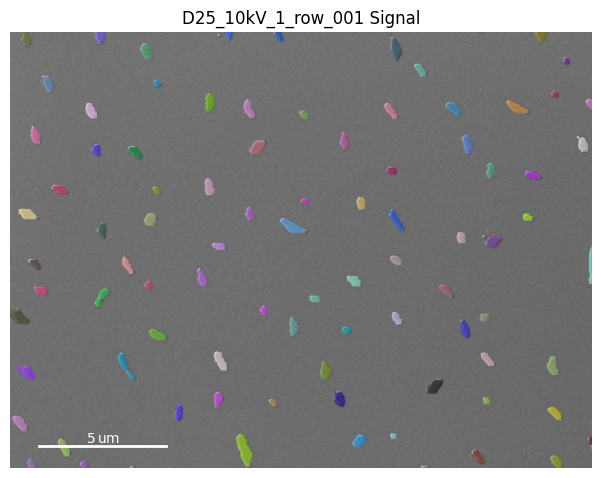

In [36]:
img = hs.load(promt_folder_files[0])
#set signal scales
img.axes_manager[0].scale = px_size/10**3
img.axes_manager[1].scale = px_size/10**3
img.axes_manager[0].units = 'um'
img.axes_manager[1].units = 'um'
img.plot(axes_ticks='off', 
            # scalebar=True
            )
plt.show()

### Chech the results of segmentation for individual particle

In [ ]:
import re
particles_folder = [f.path for f in os.scandir(path_to_save_particles) if f.is_dir()]
particles_folder_files = glob.glob(particles_folder[0]+'/*.png')
# Function to extract number from file name
def extract_number(file_path):
    match = re.search(r'(\d+)(?=\.\w+$)', file_path)
    return int(match.group(0)) if match else float('inf')

# Sort
particles_folder_files.sort(key=extract_number)
for file in particles_folder_files:
    print(file)

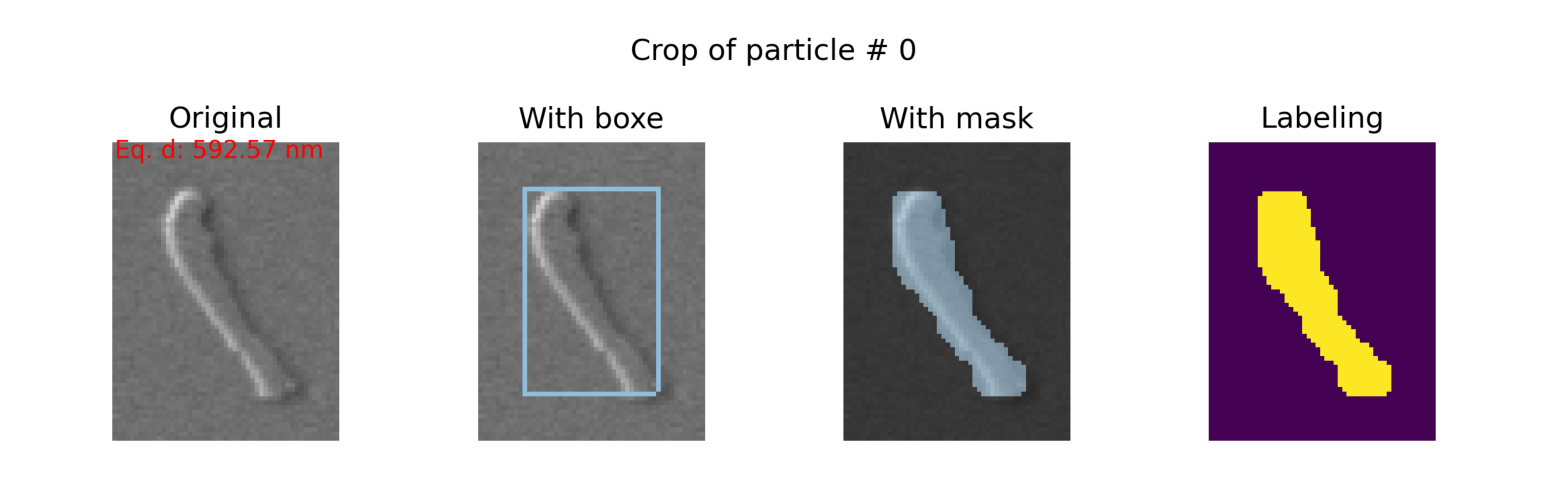

In [65]:
img_masks = cv2.imread(particles_folder_files[0])
fig, ax = plt.subplots(1,1, dpi=300)
ax.imshow(cv2.cvtColor(img_masks, cv2.COLOR_BGR2RGB))
ax.axis('off')
plt.show()